<a href="https://colab.research.google.com/github/eriosta/neuro/blob/main/Hierarchical_Clustering_of_Spatial_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hierarchical Clustering of Spatial Correlation

## Background
- **fMRI:** Reveals dynamic brain activities and allows visualization of active brain regions.
- **Challenge:** Decompose data into functionally meaningful components. The component count "N" influences decomposition granularity.
- **Tradeoff:** Higher N = finer resolution, but demands more computation.

## Aims
- Identify the "optimal" N: Maximum functional detail without excess computation.
- Determine the best N-low and N-high combo for the highest significant positive correlation.

## Approach
1. **Setup:** Use ADHD200 resting-state fMRI dataset and import required tools like nilearn.
2. **Decomposition:** Decompose fMRI data into varying component numbers via DictLearning.
3. **Correlation:** Measure correlation between low and high order components using Pearson's coefficient.
4. **Optimization:** Loop through N-low & N-high combinations, seeking max cumulative positive correlation.
5. **Visualization:** Use heatmaps to depict correlations, highlighting patterns and strength.


In [3]:
!pip install -q nilearn
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.decomposition import DictLearning
from nilearn import plotting, image
from scipy.stats import pearsonr
from nilearn import datasets, image
from nilearn.decomposition import DictLearning
import matplotlib.pyplot as plt

## Grid Search for Optimal N

Enter the minimum value for the range: 5
Enter the maximum value for the range: 20
Enter the significance level (default is 0.05): 0.01


Calculating Correlations:  50%|███████████████████▌                   | 3/6 [01:22<00:57, 19.19s/it]/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
Calculating Correlations:  67%|██████████████████████████             | 4/6 [01:23<00:23, 11.90s/it]/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
Calculating Correlations:  83%|████████████████████████████████▌      | 5/6 [01:26<00:08,  8.70s/it]/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
Calculating Correlations: 100%|███████████████████████████


Average time per combination: 14.51s
Estimated total time: 87.09s
Optimal N-low: 15, N-high: 20, with cumulative r: 78.270


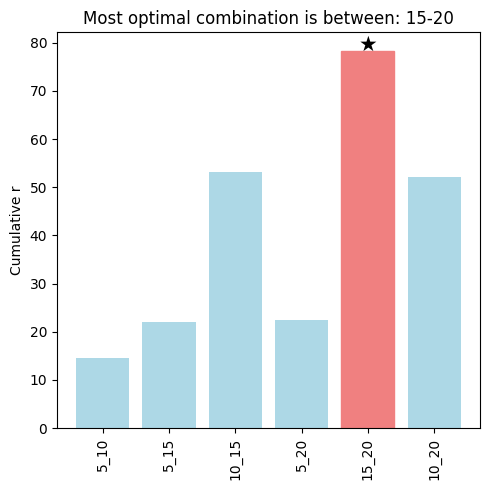

In [9]:
import numpy as np
import warnings
import time
import concurrent.futures
from tqdm import tqdm
from nilearn import datasets
from nilearn.decomposition import DictLearning
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)

class ComponentCorrelationCalculator:
    """Calculate and analyze the correlation between components of fMRI data."""

    def __init__(self, n_low_order, n_high_order, func_filenames, alpha=0.05):
        self.n_low_order = n_low_order
        self.n_high_order = n_high_order
        self.func_filenames = func_filenames
        self.alpha = alpha

    def _decompose(self, n_components):
        dict_learn = DictLearning(n_components=n_components, random_state=0)
        return dict_learn.fit_transform(self.func_filenames)

    def perform_decomposition(self):
        self.components_img_low = self._decompose(self.n_low_order)
        self.components_img_high = self._decompose(self.n_high_order)

    def compute_correlation_matrix(self):
        matrix = np.zeros((self.n_low_order, self.n_high_order))

        for i in range(self.n_low_order):
            for j in range(self.n_high_order):
                data_low = self.components_img_low[0][..., i]
                data_high = self.components_img_high[0][..., j]
                correlation, p_value = pearsonr(data_low.ravel(), data_high.ravel())

                if p_value < self.alpha:
                    matrix[i, j] = correlation

        return np.nan_to_num(matrix)

    def calculate_component_correlation(self):
        self.perform_decomposition()
        correlation_matrix = self.compute_correlation_matrix()
        positive_r = correlation_matrix[correlation_matrix > 0].sum()
        return self.n_low_order, self.n_high_order, positive_r

def optimize_components(n_low_range, n_high_range, func_filenames, alpha):
    best_values = {"n_low": None, "n_high": None, "cumulative_r": -np.inf}
    results = []

    valid_combinations = [(n_low, n_high) for n_low in n_low_range for n_high in n_high_range if n_high > n_low]
    total_combinations = len(valid_combinations)

    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = [executor.submit(ComponentCorrelationCalculator(n_low, n_high, func_filenames, alpha).calculate_component_correlation) for n_low, n_high in valid_combinations]

        start_time = time.time()

        for future in tqdm(concurrent.futures.as_completed(futures), total=total_combinations, desc="Calculating Correlations", ncols=100):
            n_low, n_high, positive_r = future.result()
            results.append((f"{n_low}_{n_high}", positive_r))
            if positive_r > best_values["cumulative_r"]:
                best_values = {"n_low": n_low, "n_high": n_high, "cumulative_r": positive_r}

        elapsed_time = time.time() - start_time
        avg_time_per_combination = elapsed_time / total_combinations
        print(f"\nAverage time per combination: {avg_time_per_combination:.2f}s")
        print(f"Estimated total time: {elapsed_time:.2f}s")

    return best_values, results

def plot_results(results, best_combo):
    labels, values = zip(*results)
    max_value = max(values)
    max_idx = values.index(max_value)

    plt.figure(figsize=(5,5))
    bars = plt.bar(labels, values, color='lightblue')
    bars[max_idx].set_color('lightcoral')
    plt.xticks(rotation=90)
    plt.annotate('★', (max_idx, max_value + 0.1), ha='center', color='black', fontsize=15)
    plt.ylabel('Cumulative r')
    plt.title(f'Most optimal combination is between: {best_combo}')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    min_value = int(input("Enter the minimum value for the range: "))
    max_value = int(input("Enter the maximum value for the range: "))
    alpha = float(input("Enter the significance level (default is 0.05): ") or "0.05")
    n_low_range = range(min_value, max_value + 1, 5)
    n_high_range = n_low_range

    adhd_dataset = datasets.fetch_adhd(n_subjects=1)

    best_values, results = optimize_components(n_low_range, n_high_range, adhd_dataset.func, alpha)
    print(f"Optimal N-low: {best_values['n_low']}, N-high: {best_values['n_high']}, with cumulative r: {best_values['cumulative_r']:.3f}")
    plot_results(results, f"{best_values['n_low']}-{best_values['n_high']}")


## Hierarchical Clustering

Enter the number of low-order components: 15
Enter the number of high-order components: 20


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


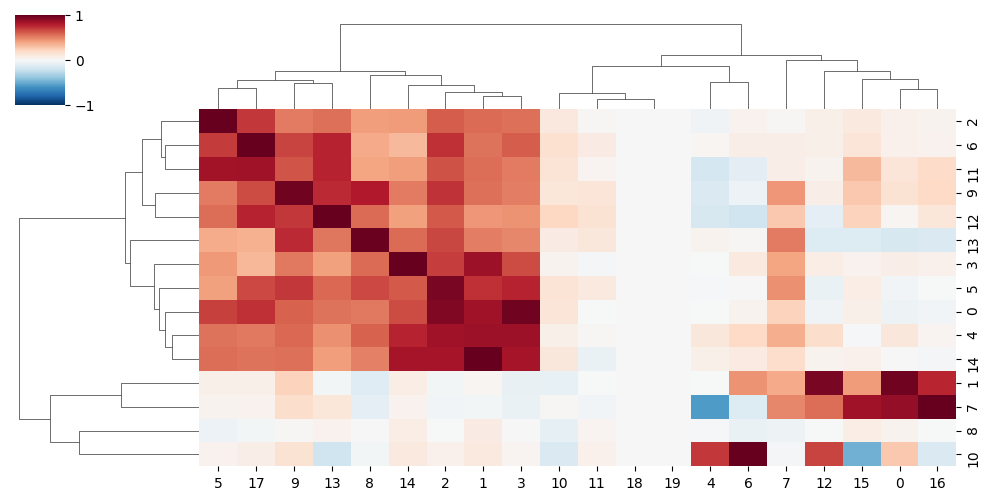

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nilearn import datasets
from nilearn.decomposition import DictLearning
from scipy.stats import pearsonr

class ComponentCorrelationVisualizer:
    def __init__(self, n_low_order, n_high_order, memory_level=2, cache_dir="nilearn_cache"):
        self.n_low_order = n_low_order
        self.n_high_order = n_high_order
        self.memory_level = memory_level
        self.cache_dir = cache_dir

    def _fetch_data(self):
        n_subjects = 1
        adhd_dataset = datasets.fetch_adhd(n_subjects=n_subjects)
        self.func_filenames = adhd_dataset.func

    def _perform_decomposition(self):
        options = {
            "random_state": 0,
            "memory": self.cache_dir,
            "memory_level": self.memory_level
        }

        dict_learn_low = DictLearning(n_components=self.n_low_order, **options)
        self.components_img_low = dict_learn_low.fit_transform(self.func_filenames)

        dict_learn_high = DictLearning(n_components=self.n_high_order, **options)
        self.components_img_high = dict_learn_high.fit_transform(self.func_filenames)

    def _compute_correlation_matrix(self):
        self.correlation_matrix = np.zeros((self.n_low_order, self.n_high_order))
        self.results = []

        for i in range(self.n_low_order):
            for j in range(self.n_high_order):
                data_low = self.components_img_low[0][..., i]
                data_high = self.components_img_high[0][..., j]
                correlation, p_value = pearsonr(data_low.ravel(), data_high.ravel())

                self.results.append({
                    'Low_Order_Component': i,
                    'High_Order_Component': j,
                    'Pearson_r': correlation,
                    'p_value': p_value
                })
                self.correlation_matrix[i, j] = correlation

        # Handle invalid values
        self.correlation_matrix = np.nan_to_num(self.correlation_matrix, nan=0.0, posinf=0.0, neginf=0.0)

    def _plot_heatmap(self):
        diverging_cmap = plt.cm.RdBu_r
        figsize = (10, 5)
        sns.clustermap(
            self.correlation_matrix,
            method="average",
            cmap=diverging_cmap,
            vmin=-1,
            vmax=1,
            annot=False,
            fmt=".2f",
            figsize=figsize
        )

    def export_results_to_csv(self, filename="correlation_results.csv"):
        df = pd.DataFrame(self.results)
        df = df.sort_values(by='p_value')
        df.to_csv(filename, index=False)

    def visualize_component_correlation(self):
        self._fetch_data()
        self._perform_decomposition()
        self._compute_correlation_matrix()
        self._plot_heatmap()
        self.export_results_to_csv()

if __name__ == "__main__":
    n_low_order = int(input("Enter the number of low-order components: "))
    n_high_order = int(input("Enter the number of high-order components: "))

    visualizer = ComponentCorrelationVisualizer(n_low_order, n_high_order)
    visualizer.visualize_component_correlation()


In [6]:
pd.read_csv('/content/correlation_results.csv').dropna()

,Low_Order_Component,High_Order_Component,Pearson_r,p_value
0,0,6,0.996001,1.832646e-184
1,2,0,0.994206,1.747825e-170
2,4,17,0.990479,8.733467e-152
3,1,1,0.970722,1.034580e-109
4,1,2,0.930590,7.423474e-78
...,...,...,...,...
85,2,11,-0.008260,9.133619e-01
86,4,4,-0.008038,9.156786e-01
87,2,13,-0.006439,9.324128e-01
88,2,1,0.005723,9.399105e-01


## No Clustering


In [8]:
# # @title {display-mode: "form"}

# # This code will be hidden when the notebook is loaded.

# import numpy as np
# import matplotlib.pyplot as plt
# from nilearn import datasets
# from nilearn.decomposition import DictLearning

# def fetch_data(n_subjects=1):
#     """Fetch the ADHD200 resting-state fMRI dataset."""
#     return datasets.fetch_adhd(n_subjects=n_subjects)

# def decompose_data(n_components, func_filenames):
#     """Decompose the data into a given number of components."""
#     dict_learn = DictLearning(n_components=n_components, random_state=0, memory="nilearn_cache", memory_level=2)
#     return dict_learn.fit_transform(func_filenames)

# def compute_correlation(components_img_1, components_img_2):
#     """Compute the spatial correlations between two sets of components."""
#     n_comp_1, n_comp_2 = components_img_1[0].shape[-1], components_img_2[0].shape[-1]
#     correlation_matrix = np.zeros((n_comp_1, n_comp_2))

#     for i in range(n_comp_1):
#         for j in range(n_comp_2):
#             data_1, data_2 = components_img_1[0][..., i], components_img_2[0][..., j]
#             correlation = np.corrcoef(data_1.ravel(), data_2.ravel())[0, 1]
#             correlation_matrix[i, j] = correlation

#     return correlation_matrix

# def plot_heatmap(correlation_matrix):
#     """Visualize the correlation matrix using a heatmap."""
#     plt.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)

#     rows, cols = correlation_matrix.shape
#     for i in range(rows):
#         for j in range(cols):
#             text = ''
#             if correlation_matrix[i, j] < 0.001:
#                 text = '**'
#             elif correlation_matrix[i, j] < 0.05:
#                 text = '*'
#             plt.text(j, i, text, ha='center', va='center', color='black')

#     plt.colorbar()
#     plt.xlabel("Set 2 Components")
#     plt.ylabel("Set 1 Components")
#     plt.title("Spatial Correlation between Components")
#     plt.show()

# if __name__ == "__main__":
#     n_comp_set1 = int(input("Enter the number of components for the first decomposition: "))
#     n_comp_set2 = int(input("Enter the number of components for the second decomposition: "))

#     # Fetch the data
#     func_filenames = fetch_data().func

#     # Decompose data for both sets of components
#     components_img_1 = decompose_data(n_comp_set1, func_filenames)
#     components_img_2 = decompose_data(n_comp_set2, func_filenames)

#     # Compute correlation matrix
#     correlation_matrix = compute_correlation(components_img_1, components_img_2)

#     # Plot the heatmap
#     plot_heatmap(correlation_matrix)
